# LSTMs for generation

You should let this file run completely in order to let it install packages, train all models, generate some training data, generate serialized data related files. 

In this notebook (python 3.12.10) I present and describe some LSTM based text generation models. I have trained them and generated text using them locally, training these models too extensively was a bit slow. I investigated their behavior while training, this in terms 
of loss evolution and by personally assessing the quality of the generated text.

I gradually adapted the model to end up with a model that handles multi-headed Transformer-like attention. 

In total I have the original basic lstm word generation model, a more advanced model containing a transformer-like attention mechanism, and a model with a multiheaded attention mechanism.

The original corpus contained seven English books on Harry Potter. Even though I have only added one here.

When executed in the right order, a "trained_models" directory gets created for saving data related to trained models.

I wanted to add 3 already trained models in a directory "trained_models_", but they were too big.  Eventually I ended up adding some info on how they were trained and the texts they generated.  Too be able to train the models in this notebook, I have limited the number of lstm layers, and the hidden and embedded dimensions.

The last part is a part on training the model using pytorch_lightning, a library which contains all kinds of additional functionality.

I also added a second notebook on optimizers.

#### Disclaimer

I think this notebook should run flawlessly until the end, if it doesn't do this, please contact me, I will correct it.
Every time I thought I had finished the notebook and had it run all of its code, something needed some change. 
And while running this notebook takes some time, this keeps me from handing in the assignment.

In [1]:
%pip install torch
%pip install PathLib
%pip install nltk
%pip install wakepy
%pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import torch
from torch import nn, Tensor, FloatTensor
import torch.nn.functional as F

In [3]:
import pickle
import re
from collections import Counter
import nltk
import numpy as np
import torch
import pathlib

Defining and creating some directories.

In [4]:
DATADIR = 'data'
DATA_RELATED_DIR = 'data_related'
TRAINED_MODELS_DIR = 'trained_models'
HP_TEXT_DIR = pathlib.Path(DATADIR).joinpath('harry_potter_text')
dirs=[DATA_RELATED_DIR, TRAINED_MODELS_DIR]
for dir in dirs:
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)

### Generate a vocabulary

This method to generate a vocabulary is in fact too complicated, but it does the job.

In [5]:
def generate_vocabulary(individual_words, min_threshold, include_special_tokens=False):
    """
    Return {token: index} for all train tokens (words) that occur min_threshold times or more,
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    """
    #create a list of words that happen min_threshold times or more in that string
    condition_keys = sorted([key for key, value in Counter(individual_words).items() if value >= min_threshold])
    #generate the vocabulary(dictionary)


    if not include_special_tokens:
        result = dict(zip(condition_keys, range(len(condition_keys))))
        return result
    else:
        result = dict(zip(condition_keys, range(3,len(condition_keys)+3)))
        orig = {"BOS": 0, "EOS": 1, "UNK": 2}
        orig.update(result)
        return orig

### Get text

This piece of code takes all text files in a directory, and does some cleaning, substitutes 'weird' characters using a regular expression. And finally it returns and saves the cleaned text. If cleaned text is already created it opens the file, and deserializes the it. 

In [6]:
def get_hp_text():
    text_files = pathlib.Path(HP_TEXT_DIR).iterdir()
    path_to_hp_text = pathlib.Path(DATA_RELATED_DIR).joinpath("harry_potter_text.pkl")

    if not path_to_hp_text.exists():
        all_text = ""
        for book in text_files:
             
             path_to_book = pathlib.Path(book)

             with open(path_to_book, "r", encoding="utf8") as f:
                text = f.readlines()

             text = [line for line in text if "Page" not in line]
             text = " ".join(text).replace("\n", "")
             text = [word for word in text.split(" ") if len(word) > 0]

             text = " ".join(text)
             text = re.sub("[^a-zA-Z0-9-_*.!,? \"\']", "", text)
             all_text+=text

        with open(path_to_hp_text, 'wb') as handle:
            pickle.dump(all_text, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(path_to_hp_text, 'rb') as handle:
            all_text = pickle.load(handle)

    return all_text

### Get tokens

The cleaned text returned from the previous function is used to create tokenids. As I am not that specialized in language models, I have used some tokenizer, not knowing whether it is the best option. I am just happy to get some tokens. The tokens are serialized and saved, for later reuse. Again I serialize the tokenize text, for later reuse.

In [7]:
def get_tokens():
    path_to_tokens = pathlib.Path(DATA_RELATED_DIR).joinpath("harry_potter_tokens.pkl")
    if not path_to_tokens.exists():
        tokens=nltk.word_tokenize(get_hp_text())
        with open(path_to_tokens, 'wb') as handle:
            pickle.dump(tokens, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(path_to_tokens, 'rb') as handle:
            tokens = pickle.load(handle)
    return tokens

### Vocabularies

The tokens are used to generate two complementary vocabularies. The vocabularies are serialized on creation. And can be reused when rerunning.

In [8]:
def get_2_vocabs():
    path_to_vocab= pathlib.Path(DATA_RELATED_DIR).joinpath("harry_potter_vocab.pkl")
    path_to_inv_vocab = pathlib.Path(DATA_RELATED_DIR).joinpath("harry_potter_inv_vocab.pkl")
    tokens= get_tokens()
    if not path_to_vocab.exists():
        vocab=generate_vocabulary(tokens, 1)
        inv_vocab = {v: k for k, v in vocab.items()}

        with open(path_to_vocab, 'wb') as handle:
            pickle.dump(vocab, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(path_to_inv_vocab, 'wb') as handle:
            pickle.dump(inv_vocab, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(path_to_vocab, 'rb') as handle:
             vocab= pickle.load(handle)
        with open(path_to_inv_vocab, 'rb') as handle:
             inv_vocab= pickle.load(handle)

    return vocab, inv_vocab

### Data generator

Using the corpus a datagenerator is created. The tokenized data is written to a numpy memmap file. This memmap allows for RAM like access to data. So no complete tokenized text file somewhere in RAM, only the tokenized part needed for the 'batch in process' in memory.

### Data

The data is produced by the simple class below, it produces batches of source sentences (X) and the sentences that should be produced (the target or  y) when the model is presented with some sentence.

So if the sentence from which to create a new token would be:

` To be or not to be, that's the `

Then the 'target' sentence could be

` be or not to be, that's the question `

The path_to_memmap parameter refers to a complete tokenized version of the complete text, which is sliced using random int values, while keeping some preset sequence length.

In [9]:
class DataBuilderMemmap:
    def __init__(self, path_to_memmap, shape_of_memmap,seq_len,  word2idx={}, idx2word={}):
        self.seq_len = seq_len
        self.number_of_tokens = shape_of_memmap[0]
        self.word2idx=word2idx
        self.idx2word=idx2word
        self.path_to_memmap = path_to_memmap
        self.shape_of_memmap = shape_of_memmap
        self.tokens = np.memmap(self.path_to_memmap, dtype=np.int32, mode='r', shape=self.shape_of_memmap)
    def grab_random_sample(self):
        start = np.random.randint(0, self.number_of_tokens - self.seq_len)
        end = start + self.seq_len
        text_slice = self.tokens[start:end].copy()

        input_text = torch.from_numpy(text_slice[:-1])
        label = torch.from_numpy(text_slice[1:])

        return input_text, label

    def grab_random_batch(self, batch_size):
        input_texts, labels = [], []

        for _ in range(batch_size):
            input_text, label = self.grab_random_sample()

            input_texts.append(input_text)
            labels.append(label)

        input_texts = torch.stack(input_texts)
        labels = torch.stack(labels)

        return input_texts, labels

### Creation of memmap, data generator

The following two methods create the memmap and the data generator. When rerunning the complete notebook the memmap generates an error, because some references aren't cleaned up properly. 

'hp_map.dat' in the code below should then be given another name, in order to be recreated. But when first running the code shouldn't generate a problem. Restarting the notebook is another option.

In [10]:
from tempfile import mkdtemp
#from pathlib import Path
import tempfile
import os
def create_memmap(tokenized_text, word2idx, name):
    #path_to_memmap = pathlib.Path().cwd().joinpath(DATA_RELATED_DIR,name)

    path_to_memmap = os.path.join(mkdtemp(), name)

    tt=np.asarray([word2idx[w] for w in tokenized_text], dtype=np.int32)
    f = np.memmap(path_to_memmap, dtype=np.int32, mode='w+', shape=tt.shape)
    f[:] = tt[:]

    return path_to_memmap, tt.shape


def get_databuildermemmap(seq_len, tokens, word2idx, idx2word, name):
    path_to_memmap, shape_of_memmap = create_memmap(tokens, word2idx, name)

    db=DataBuilderMemmap(path_to_memmap, shape_of_memmap,seq_len,  word2idx, idx2word)
    return db

Even after pip installing nltk. Sometimes a part of the nltk library should be manually downloaded. The nltk library contains the tokenizer.

In [13]:
nltk.download('punkt_tab')
import numpy as np
import torch
from torch import nn, Tensor, FloatTensor
import torch.nn.functional as F

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\wilfr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Simple word generation model

### Forward method

This model is a simple model found on [PyTorch-Adventures](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20NLP/Recurrent%20Neural%20Networks/Harry%20Potter%20Generation/Harry%20Potter%20Writer.ipynb). Its forward method takes in a complete sentence, produces an embedding, passes this embedding to the LSTM block which creates an output that is passed to a linear layer to produce logits, for every input token. As a complete sequence of text is passed to an LSTM at once, no further adaptations can be applied during training. 

### Write method

Contrary to the forward method, the write method generates one token at the time. In this way multiple types of generations are possible. Furthermore it doesn't differ that much from the forward method, it just produces one token at the time. And allows for different ways of text generation, just pick the next token that is most probable. The other option selects a token uisng probabilities, so basically even the worst fit could be chosen.


In [14]:
class LSTMForWordGeneration(nn.Module):
    def __init__(self, word2idx, idx2word,embedding_dim=128, hidden_size=256, n_layers=3):
        super().__init__()
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.embedding_dim = embedding_dim
        self.num_words = len(word2idx)
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(self.num_words, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=n_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, self.num_words)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.embedding(x)
        output, (h, c) = self.lstm(x)
        logits = self.fc(output)
        return logits

    def write(self, text, max_words, greedy=False):

        idx = torch.tensor([self.word2idx[w] for w in text])
        hidden = torch.zeros(self.n_layers, self.hidden_size)
        cell = torch.zeros(self.n_layers, self.hidden_size)

        for i in range(max_words):

            if i == 0:
                selected_idx = idx
            else:
                selected_idx = idx[-1].unsqueeze(0)

            x = self.embedding(selected_idx)
            out, (hidden, cell) = self.lstm(x, (hidden, cell))

            out = self.fc(out)

            if len(out) > 1:
                out = out[-1, :].unsqueeze(0)

            probs = self.softmax(out)

            if greedy:
                idx_next = torch.argmax(probs).squeeze(0)
            else:
                idx_next = torch.multinomial(probs, num_samples=1).squeeze(0)

            idx = torch.cat([idx, idx_next])

        gen_string = [self.idx2word[int(w)] for w in idx]
        gen_string = " ".join(gen_string)

        return gen_string

### Training

The loss function is cross entropy loss. Cross-entropy loss is a measure of the difference between two probability distributions, the ground truth distribution P and the predicted distribution Q of the model. 

#### AdamW

The optimizer is AdamW. AdamW is an optimization algorithm, developed as a modification to the Adam optimizer to decouple weight decay from gradient-based updates. This decoupling was introduced to address overfitting issues that often arise when using standard Adam, especially for large-scale neural network models.

#### Data produced

The training function produces some data like loss, text produced, the trained model itself. This data can be found in the "trained_model" directory. The configuration file is saved there too, for referral afterwwards.

For the more advanced models a write_better is used to generate text using a beam_search algorithm.

In [15]:
from pathlib import Path
import pandas as pd
from torch import optim, nn
import gc

def train(model, word2idx, idx2word, tokens, config, write_better=False):
    training_data = {
        "model":[],
        "iteration":[],
        "training data length":[],
        "loss": [],
        "generated text": []
    }
    texts_generated = {
        "iteration": [],
        "loss":[],
        "probabilities":[],
        "texts": [],
    }

    name=model.__class__.__name__
    new_dir = pathlib.Path(TRAINED_MODELS_DIR).joinpath(name)
    new_dir.mkdir(parents=True, exist_ok=True)

    iterations = config["iterations"]
    max_len = config["max_len"]
    evaluate_interval = config["evaluate_interval"]
    lr = config["lr"]
    batch_size = config["batch_size"]

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    np.random.seed(0)
    dataset = get_databuildermemmap(max_len, tokens, word2idx, idx2word, 'dat_memmap.dat')
    model.train()
    for iteration in range(iterations):

        input_texts, labels = dataset.grab_random_batch(batch_size=batch_size)
        input_texts, labels = input_texts, labels
        optimizer.zero_grad()
        output = model(input_texts)
        output = output.transpose(1,2)

        loss = loss_fn(output, labels.long())

        loss.backward()
        optimizer.step()

        if iteration % evaluate_interval == 0:
            model.eval()
            torch.no_grad()
            print("--------------------------------------")
            print(f"training data length {max_len}")
            print(f"Iteration {iteration}")
            print(f"Loss {loss.item()}")
            generated_text = model.write(["Spells"], max_words=50)
            print(generated_text)
            if write_better:
                generated_texts, probabilities = model.write_better(["Spells"],max_words=50, k=3)
                print("Sample Generation")
                for text, probability in zip(generated_texts, probabilities):
                    print(f"text: {text} probability: {probability}")
            print("--------------------------------------")
            training_data["model"].append(name)
            training_data["iteration"].append(iteration)
            training_data["training data length"].append(max_len)
            training_data["loss"].append(loss.item())
            training_data["generated text"].append(generated_text)

            if write_better:
                texts_generated["iteration"].append(iteration)
                texts_generated["loss"].append(loss.item())
                texts_generated["probabilities"].append(probabilities)
                texts_generated["texts"].append(generated_texts)

            torch.enable_grad()
            model.train()
    td=pd.DataFrame(training_data)
    td.set_index(["model", "iteration"])
    td.to_csv(pathlib.Path(TRAINED_MODELS_DIR).joinpath(name,"training_data.csv"), encoding="utf8")
    cd=pd.DataFrame(list(config.items()), columns=["key", "value"])

    cd.to_csv(pathlib.Path(TRAINED_MODELS_DIR).joinpath(name,"config_data.csv"), encoding="utf8", index=False)

    if write_better:
        with open(pathlib.Path(TRAINED_MODELS_DIR).joinpath(name,'generated_texts.pkl'), 'wb') as fh:
            pickle.dump(texts_generated, fh, protocol=pickle.HIGHEST_PROTOCOL)

    torch.save(model.state_dict(), pathlib.Path(TRAINED_MODELS_DIR).joinpath(name+"/model_state.pth"))
    #del dataset
    #del f
    #gc.collect()

### Basic configuration

To setup the basic model and some training parameters. I used some configuration dictionary. This some basic training and model parameters.

In [16]:
def get_config():
    config={}
    config["iterations"]=300
    config["max_len"]=20
    config["evaluate_interval"]=30
    config["embedding_dim"]=128
    config["hidden_size"]=256
    config["n_layers"]=2
    config["lr"]=0.003
    config["batch_size"]=64
    config["bidirectional"]=False
    return config

In [17]:
import pandas as pd

conf = get_config()
import pandas as pd
data = {'keys':conf.keys() , 'value': conf.values()}

df = pd.DataFrame(data)
latex_table = df.to_latex(index=False)
print(latex_table)

\begin{tabular}{ll}
\toprule
keys & value \\
\midrule
iterations & 300 \\
max_len & 20 \\
evaluate_interval & 30 \\
embedding_dim & 128 \\
hidden_size & 256 \\
n_layers & 2 \\
lr & 0.003000 \\
batch_size & 64 \\
bidirectional & False \\
\bottomrule
\end{tabular}



### Getting data

Get the data and related constructs.

In [18]:
text = get_hp_text()
tokens = get_tokens()
word2idx, idx2word = get_2_vocabs()

### Start training

Initializing the model.

In [19]:
from wakepy import keep 
config=get_config()
model = LSTMForWordGeneration(word2idx, idx2word, embedding_dim=config["embedding_dim"],
                                      hidden_size=config["hidden_size"], n_layers=config["n_layers"])
with keep.running():
    train(model, word2idx, idx2word, tokens, config, write_better=False)

--------------------------------------
training data length 20
Iteration 0
Loss 8.843012809753418
Spells drunk admired Curses well destined SEIZE reflections Mighta Ollivanders honor borrow Vol- upper corridor transfixed damn split Curse wantin began manner shouted sleeve fur penalty out lumpy relaxed frowned silver SNAKE Hat flame Tried Flocks puffed relax wish dives replaced boats broken-down luck damage powerful easy bother Erm tabby Wingardium
--------------------------------------
--------------------------------------
training data length 20
Iteration 30
Loss 6.711108207702637
Spells OPEN Ron the to on forward . the door said , his I sat passed wasnt car I Whats told the search they What watch . He clean tight-lipped table said realized in , , there the Harry , wasnt the safe corner Mrs. table to him , dont his
--------------------------------------
--------------------------------------
training data length 20
Iteration 60
Loss 6.587769031524658
Spells holidays was . Harry . gol

## Attention

To get an idea of what attention means mathematically let's compare some matrix multiplications. To get an idea of what attention means mathematically let's compare some matrix multiplications. These calculations are a means of expressing the mechanisms behind attention. Most of the time q(uery) and k(ey) matrices will contain much more complexity than expressed by the matrix multiplications below.

### Some direct multiplications

Firstly, a relatively straight matrix multiplication of three matrices. In this case the third element of the q(uery) matrix is a 1, all the rest are zeroes. Matrix multiplying q with the one hot encoded k(eys) selects the third row of this k(eys) matrix. As a consequence the adapted k(eys) matrix selects the third v(alues) row. As can be seen in the last printed line.

In [20]:
import torch.nn.functional as F
import torch
q = F.one_hot(torch.tensor([2]), 5)
k = F.one_hot(torch.arange(5), 5)
v = torch.randint(2, 8, (5,2 ))
print("q")
print(q)
print("k")
print(k)
print("v")
print(v)

q_times_k=torch.mm(q,k.T)
print("q_times_k")
print(q_times_k)
print("q_times_k_times_v")
qtk_v= torch.mm(q_times_k, v)
print(qtk_v)

q
tensor([[0, 0, 1, 0, 0]])
k
tensor([[1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]])
v
tensor([[3, 2],
        [7, 3],
        [7, 7],
        [4, 6],
        [4, 4]])
q_times_k
tensor([[0, 0, 1, 0, 0]])
q_times_k_times_v
tensor([[7, 7]])


### Some softer multiplications

In this case the q(uery) isn't as decisive as before, the q matrix is softer. In a numeric world the softer values are responsible for some weighted v(alues) matrix. As the keys stay the same, every value in the v(alues) matrix counts except the first, as the first value in the q(ueriy) matrix is zero. The other v(alues) are weighted. The last printed line shows 2 different values.

In [21]:
q= torch.FloatTensor([0,0.3,0.2,0.4,0.1]).unsqueeze(0)
k = F.one_hot(torch.arange(5), 5).to(torch.float)
v = v.to(torch.float)

print("q")
print(q)

print("k")
print(k)

print("v")
print(v)

q_times_k=torch.mm(q,k.T)
print("q_times_k")
print(q_times_k)
print("q_times_k_times_v")
qtktv=torch.mm(q_times_k, v)
print("qtktv")
print(qtktv)



q
tensor([[0.0000, 0.3000, 0.2000, 0.4000, 0.1000]])
k
tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])
v
tensor([[3., 2.],
        [7., 3.],
        [7., 7.],
        [4., 6.],
        [4., 4.]])
q_times_k
tensor([[0.0000, 0.3000, 0.2000, 0.4000, 0.1000]])
q_times_k_times_v
qtktv
tensor([[5.5000, 5.1000]])


### Softer keys

As the keys of matrices in deep learning most of the times aren't that explicitly defined, I have adjusted these too, slightly, to observe some effect. I have adjusted the keys for the second k(eys) column. As a result when matrix multiplying the adjusted keys with the values the second row has changed when compared to original v(alues) tensor. This change has its effect on the final result of the complete matrix multiplication. 

In [22]:
q= torch.FloatTensor([0,0.3,0.2,0.4,0.1]).unsqueeze(0)
k = F.one_hot(torch.arange(5), 5).to(torch.float)
k[1,1]=0.5
k[2,1]=0.5
v = v.to(torch.float)

print("q")
print(q)
print("k")
print(k)
print("v")
print(v)

k_times_v = torch.mm(k.T, v)
print("k_times_v")
print(k_times_v)


q_times_k_times_v=torch.mm(q,k_times_v)
print("q_times_k_times_v")
print(q_times_k_times_v)


q
tensor([[0.0000, 0.3000, 0.2000, 0.4000, 0.1000]])
k
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]])
v
tensor([[3., 2.],
        [7., 3.],
        [7., 7.],
        [4., 6.],
        [4., 4.]])
k_times_v
tensor([[3., 2.],
        [7., 5.],
        [7., 7.],
        [4., 6.],
        [4., 4.]])
q_times_k_times_v
tensor([[5.5000, 5.7000]])


### Difference with the above idea of attention

A difference that can be observed in the Attention class definition below is the bmm operation, it is a batched version of the matrix multiplication. 

A MultiHeadedAttention module in torch exists, but I found it easier to use a custom class, it seemed easier to configure for my specific case. This class was partly found on the internet, but I need to fit it to my needs. But from what I know it is how the first Tranformer had its attention calculated.

From what I know, the torch MultiheadedAttention class can be used to implement the behavior implemented by the Attention class below. But the torch Attention has a fair bit of parameters to configure.

### Attention in words

For every timestep, a different query and value vector will be entered (the value vector is used for the key vector too) into the attention module. The attention module will adjust the timestep embedded token value using the context consisting of the surrounding embedded tokens and the hidden/h values produced by the LSTMs. In this way the embedded token value is adjusted towards its directly and indirectly related surrounding embedded token values, this happens through adjusting cell/c values.

 The whole idea of deeplearning is to adjust the weighing values for q,k,v, to adjust for multiple cases through backpropagation. Apart from backpropagation, the attention class has the same weights in every timestep, but the inputs differ from batch to batch and timestep to timestep.

Some normalisation is applied to the resutling attention scores. In the end the attention weights are matrix multiplied to the values.

### The attention usage

In my text generation case attention is used to adjust word/token embeddings to express semantical or syntactical relations between different parts of a sentence. As I only use Attention once, it can only convey the information it is capable of conveying, as a sentence can be composed of multiple semantical and syntactical twists this is probably too limited for the texts it is trained on. It should provide better results than a model without attention.

In [23]:
class Attention(nn.Module):
    def __init__(self, d_in,d_out, n_layers, n_directions=2):
        super().__init__()
        self.d_in=d_in
        self.d_out=d_out
        self.n_layers =n_layers
        self.n_directions=n_directions
        self.Q=nn.Linear(self.n_directions*self.n_layers*d_in,d_out)
        self.K=nn.Linear(d_in,d_out)
        self.V=nn.Linear(d_in,d_out)
    def forward(self,q ,x):
        queries=self.Q(q)
        keys = self.K(x)
        values = self.V(x)
        scores = torch.bmm(queries, keys.transpose(1,2))
        scores = scores/ (self.d_out**0.5)
        attention = F.softmax(scores,dim=2)
        hidden_states= torch.bmm(attention,values)
        return hidden_states

### The model with attention

It is not desirable to apply attention to an LSTM block beign used to generate the hidden and cell values, while the lstm is generating these values. So a secondary LSTM block is used to absorb the results of applying attention to the values produced by the first LSTM block.

### The write_better method

The write_better method is a beam search implementation. It should generate text better as it considers the probability of a sentence as a whole, in stead of generating a word based on the highest probable word at a particular timestep. In fact, to lower computational complexity, only a k number of possibilities are considered for every timestep. As I have tried to adapt the hidden and cell values based on the highest possible next words generated,  the method looks and is quiet complex to capture and interpret. As a matter of fact, it is a bit hard to evaluate its correctness/soundness without a properly trained model. That's why I have always kept the simpler write method as a safehaven.

### The forward method

This is the first time I am really experimenting with lstms and attention. This inspired by multiple internet searches. So the forward method is in fact no direct copy, even though it isn't that ingenious it feels like mine.  

#### What does it do

The forward method applies three steps for every timestep. The initial token is fed into the first lstm, the output thereof is fed into an attention layer, and than this weigthed result is fed into a second lstm layer. The (h, c) output of the second lstm partly influences the results of the first lstm in the next timestep. At the end of every timestep, the output of every second lstm is put into a tensor. In this way, as the data is 20 tokens long, a tensor containing the information to generate 20 next tokens is generated.


In [24]:
class LSTMForWordGenerationWithAttention(nn.Module):
    def __init__(self, word2idx, idx2word, embedding_dim=128, hidden_size=256, bidirectional=False, n_layers=3):
        super().__init__()
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.embedding_dim = embedding_dim
        self.num_words = len(word2idx)
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.num_directions = 2 if bidirectional else 1

        self.embedding = nn.Embedding(self.num_words, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=n_layers,
                            batch_first=True,
                            bidirectional=bidirectional)

        self.attention = Attention(self.embedding_dim, self.n_layers * self.num_directions * self.embedding_dim, self.n_layers, self.num_directions)

        self.lstm2 = nn.LSTM(input_size=self.n_layers * self.num_directions * self.embedding_dim,
                             hidden_size=self.n_layers * self.num_directions * self.hidden_size,
                             num_layers=1,
                             batch_first=True,
                             bidirectional=False)

        self.fc = nn.Linear(self.n_layers * self.num_directions * self.hidden_size, self.num_words)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size = x.size(0)
        output_enc_dec = FloatTensor()
        for i in range(x.shape[1]):
            x_i = self.embedding(x[:, i])
            x_i = x_i.unsqueeze(1)

            if i == 0:
                out, (hidden, cell) = self.lstm(x_i)
            else:
                out, (hidden, cell) = self.lstm(x_i, (hidden, cell))

            hidden = hidden.reshape(1, -1, self.n_layers * self.num_directions * self.hidden_size)
            cell = cell.reshape(1, -1, self.n_layers * self.num_directions * self.hidden_size)

            attention_output = self.attention(out, x_i)

            out_lstm2, (h, c) = self.lstm2(attention_output, (hidden, cell))

            hidden = torch.div(torch.add(hidden, h), 2, rounding_mode=None)
            cell = torch.div(torch.add(cell, c), 2, rounding_mode=None)

            hidden = hidden.reshape(self.n_layers * self.num_directions, batch_size, -1)
            cell = cell.reshape(self.n_layers * self.num_directions, batch_size, -1)

            output_enc_dec = torch.cat([output_enc_dec, out_lstm2.unsqueeze(1)], dim=1)

        output_enc_dec = output_enc_dec.squeeze(2)
        logits = self.fc(output_enc_dec)
        return logits

    def write(self, text, max_words, greedy=False):
        idx = torch.tensor([self.word2idx[w] for w in text])
        hidden = Tensor()
        cell = Tensor()
        for i in range(max_words):
            if i == 0:
                selected_idx = idx
            else:
                selected_idx = idx[-1].unsqueeze(0)

            x = self.embedding(selected_idx)
            x = x.unsqueeze(0)

            if i == 0:
                out, (hidden, cell) = self.lstm(x)
            else:
                out, (hidden, cell) = self.lstm(x, (hidden, cell))

            hidden1 = hidden.detach().clone().reshape(1, 1, -1)
            cell1 = cell.detach().clone().reshape(1, 1, -1)

            attention_output = self.attention(out, x)
            out_lstm2, (h, c) = self.lstm2(attention_output, (hidden1, cell1))

            out = self.fc(out_lstm2)
            out = out.squeeze(0)

            if len(out) > 1:
                out = out[-1, :].unsqueeze(0)

            probs = self.softmax(out)

            if greedy:
                idx_next = torch.argmax(probs).squeeze(0)
            else:
                idx_next = torch.multinomial(probs, num_samples=1).squeeze(0)

            idx = torch.cat([idx, idx_next])

        gen_string = [self.idx2word[int(w)] for w in idx]
        gen_string = " ".join(gen_string)
        return gen_string
    
    def write_better(self, text, max_words, k=1):
        idx = torch.tensor([self.word2idx[w] for w in text])
        k_times_idx = idx.repeat(1, k).unsqueeze(2).squeeze(0)
        hidden = Tensor()
        cell = Tensor()
        k_times_probs = Tensor([0]).repeat(k)

        for i in range(max_words):
            # print("i: ",i)
            if i == 0:
                selected_idx = k_times_idx
            else:
                selected_idx = k_times_idx[:, -1].unsqueeze(1)

            x = self.embedding(selected_idx)
            if i == 0:
                out, (hidden, cell) = self.lstm(x)
            else:
                out, (hidden, cell) = self.lstm(x, (hidden, cell))

            hidden1 = hidden.detach().clone().reshape(1, k, -1)
            cell1 = cell.detach().clone().reshape(1, k, -1)

            # apply attention
            weighted_output = self.attention(out, x)
            
            out_lstm2, (h, c) = self.lstm2(weighted_output, (hidden1, cell1))
            out_lstm2 = out_lstm2.permute(1, 0, 2)
            out = self.fc(out_lstm2)
            if len(out) > 1:
                out = out[-1, :].unsqueeze(0)

            probs = self.softmax(out)
            probs_top, i = torch.topk(probs.detach().flatten(), k=k, dim=-1, sorted=False)
            i = i.detach()
            indexes = np.array(np.unravel_index(i.numpy(), probs.shape)).T
            idx_next = torch.from_numpy(indexes[:, 2]).unsqueeze(1)
            k_times_idx = torch.cat([k_times_idx, idx_next], dim=1)
            k_times_probs = k_times_probs.add(torch.log10(probs_top))
            indices = torch.tensor(indexes[:, 1])
            hidden = torch.index_select(hidden, 1, indices)
            cell = torch.index_select(cell, 1, indices)
  

        gen_strings = []
        for i, idxs in enumerate(k_times_idx.numpy()):
            gen_string = [self.idx2word[int(w)] for w in idxs]
            gen_strings.append(" ".join(gen_string))
        probs=torch.exp(k_times_probs)
        return gen_strings, probs


### Attention model configuration

The configuration for the attention model.

In [25]:
def get_config_attention():
    config={}
    config["iterations"]=300
    config["max_len"]=20
    config["evaluate_interval"]=30
    config["embedding_dim"]=128
    config["hidden_size"]=256
    config["n_layers"]=2
    config["lr"]=0.003
    config["batch_size"]=64
    config["bidirectional"]=True
    return config


In [26]:
import pandas as pd

conf = get_config_attention()
import pandas as pd
data = {'keys':conf.keys() , 'value': conf.values()}

df = pd.DataFrame(data)
latex_table = df.to_latex(index=False)
print(latex_table)

\begin{tabular}{ll}
\toprule
keys & value \\
\midrule
iterations & 300 \\
max_len & 20 \\
evaluate_interval & 30 \\
embedding_dim & 128 \\
hidden_size & 256 \\
n_layers & 2 \\
lr & 0.003000 \\
batch_size & 64 \\
bidirectional & True \\
\bottomrule
\end{tabular}



### Training the attention based model

Training the attention based model

In [27]:
from wakepy import keep 
config=get_config_attention()
model = LSTMForWordGenerationWithAttention(word2idx, idx2word, embedding_dim=config["embedding_dim"],
                                      hidden_size=config["hidden_size"], n_layers=config["n_layers"], bidirectional=config["bidirectional"])
with keep.running():
    train(model, word2idx, idx2word, tokens, config, write_better=True)


--------------------------------------
training data length 20
Iteration 0
Loss 8.84482479095459
Spells deserved Tap toads white clock BREAK-IN gym wins introduced awaiting unwrapping courageous precious babble Leaves Auntie Course pillow directly Pasties N-not yard cheered anyones Exactly TO KEYS settled Ridge-back caution heaven this Little Unless similar woken member signature fitted striding drew sore Bring havin asleep part Marcus rumor presenting engulfed
Sample Generation
text: Spells . He was the said Harry , said the , said the , said the , said the , said the , said the , said the , said the , said the , said the , said the , said the , said the , said the , said probability: 0.0
text: Spells . He was the and the Stone and Harry door and Harry door and Harry door and Harry door and Harry door and Harry door and Harry door and Harry door and Harry door and Harry door and Harry door and Harry door and Harry door and Harry door and probability: 0.0
text: Spells . He was , the Ro

### Generating text from model

In this piece of code a short text is generated from a model. 

In [28]:
config = get_config_attention()
text = get_hp_text()
tokens = get_tokens()
word2idx, idx2word = get_2_vocabs()


config=get_config_attention()
model = LSTMForWordGenerationWithAttention(word2idx, idx2word, embedding_dim=config["embedding_dim"],
                                      hidden_size=config["hidden_size"], n_layers=config["n_layers"], bidirectional=config["bidirectional"])


generated_texts, probabilities = model.write_better(["Spells"], max_words=8, k=3)
print(probabilities)
print(generated_texts)

tensor([8.6925e-14, 8.3602e-14, 8.0922e-14])
['Spells remembers but Isle depended stream Erised Lots losing', 'Spells kid pasties right-hand flared fond spindly maybe Crockford', 'Spells whispering Thomas Flew rumbling hygienic fumbling peculiar tune']


## The multiheaded attention based model

As I already told, simple attention may be a bit limited for language generation, so the next model is equipped with multiheaded attention. Attention as defined above could be called one-headed attention, while using this one-headed attention twice could be named two-headed attention. Multi-headed attention allows for a model to use two or more different channels of attention. In this way multiple interpretations of a piece of text can be conveyed over different timesteps.

In [29]:
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in,d_out, n_layers, n_directions ,num_heads):
        super().__init__()
        self.heads = nn.ModuleList(
            [Attention(d_in,d_out, n_layers, n_directions) for _ in range(num_heads)]
        )

    def forward(self,q, x):
        return torch.cat([head(q,x) for head in self.heads], dim=-1)

As the only difference with the attention model is the multiheaded attention part, methods don't differ that much from the attention based model.

In [30]:
import numpy as np
import torch
from torch import nn, Tensor, FloatTensor


class LSTMForWordGenerationWithMHAttention(nn.Module):
    def __init__(self, word2idx, idx2word, embedding_dim=128, hidden_size=256, bidirectional=False, n_layers=3, n_heads=2):
        super().__init__()
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.embedding_dim = embedding_dim
        self.num_words = len(word2idx)
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.num_directions = 2 if bidirectional else 1

        self.embedding = nn.Embedding(self.num_words, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=n_layers,
                            batch_first=True,
                            bidirectional=bidirectional)

        self.attention = MultiHeadAttentionWrapper(self.embedding_dim, self.n_layers * self.num_directions * self.embedding_dim, self.n_layers, self.num_directions,self.n_heads)

        self.lstm2 = nn.LSTM(input_size=self.n_heads*self.n_layers * self.num_directions * self.embedding_dim,
                             hidden_size=self.n_layers * self.num_directions * self.hidden_size,
                             num_layers=1,
                             batch_first=True,
                             bidirectional=False)

        self.fc = nn.Linear(self.n_layers * self.num_directions * self.hidden_size, self.num_words)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size = x.size(0)
        output_enc_dec = FloatTensor()
        for i in range(x.shape[1]):
            x_i = self.embedding(x[:, i])
            x_i = x_i.unsqueeze(1)

            if i == 0:
                out, (hidden, cell) = self.lstm(x_i)
            else:
                out, (hidden, cell) = self.lstm(x_i, (hidden, cell))

            hidden = hidden.reshape(1, -1, self.n_layers * self.num_directions * self.hidden_size)
            cell = cell.reshape(1, -1, self.n_layers * self.num_directions * self.hidden_size)


            attention_output = self.attention(out, x_i)

            out_lstm2, (h, c) = self.lstm2(attention_output, (hidden, cell))

            hidden = torch.div(torch.add(hidden, h), 2, rounding_mode=None)
            cell = torch.div(torch.add(cell, c), 2, rounding_mode=None)

            hidden = hidden.reshape(self.n_layers * self.num_directions, batch_size, -1)
            cell = cell.reshape(self.n_layers * self.num_directions, batch_size, -1)

            output_enc_dec = torch.cat([output_enc_dec, out_lstm2.unsqueeze(1)], dim=1)

        output_enc_dec = output_enc_dec.squeeze(2)
        logits = self.fc(output_enc_dec)
        return logits

    def write(self, text, max_words, greedy=False):
        idx = torch.tensor([self.word2idx[w] for w in text])
        hidden = Tensor()
        cell = Tensor()
        for i in range(max_words):
            if i == 0:
                selected_idx = idx
            else:
                selected_idx = idx[-1].unsqueeze(0)

            x = self.embedding(selected_idx)
            x = x.unsqueeze(0)

            if i == 0:
                out, (hidden, cell) = self.lstm(x)
            else:
                out, (hidden, cell) = self.lstm(x, (hidden, cell))

            hidden1 = hidden.detach().clone().reshape(1, 1, -1)
            cell1 = cell.detach().clone().reshape(1, 1, -1)

            attention_output = self.attention(out, x)
            out_lstm2, (h, c) = self.lstm2(attention_output, (hidden1, cell1))

            out = self.fc(out_lstm2)
            out = out.squeeze(0)

            if len(out) > 1:
                out = out[-1, :].unsqueeze(0)

            probs = self.softmax(out)

            if greedy:
                idx_next = torch.argmax(probs).squeeze(0)
            else:
                idx_next = torch.multinomial(probs, num_samples=1).squeeze(0)

            idx = torch.cat([idx, idx_next])

        gen_string = [self.idx2word[int(w)] for w in idx]
        gen_string = " ".join(gen_string)
        return gen_string

    def write_better(self, text, max_words, k=1):
        idx = torch.tensor([self.word2idx[w] for w in text])
        k_times_idx = idx.repeat(1, k).unsqueeze(2).squeeze(0)
        hidden = Tensor()
        cell = Tensor()
        k_times_probs = Tensor([0]).repeat(k)

        for i in range(max_words):
            if i == 0:
                selected_idx = k_times_idx
            else:
                selected_idx = k_times_idx[:, -1].unsqueeze(1)

            x = self.embedding(selected_idx)
            if i == 0:
                out, (hidden, cell) = self.lstm(x)
            else:
                out, (hidden, cell) = self.lstm(x, (hidden, cell))

            hidden1 = hidden.detach().clone().reshape(1, k, -1)
            cell1 = cell.detach().clone().reshape(1, k, -1)
            # apply attention
            weighted_output = self.attention(out, x)
            out_lstm2, (h, c) = self.lstm2(weighted_output, (hidden1, cell1))
            out_lstm2 = out_lstm2.permute(1, 0, 2)
            out = self.fc(out_lstm2)


            if len(out) > 1:
                out = out[-1, :].unsqueeze(0)

            probs = self.softmax(out)

            probs_top, i = torch.topk(probs.detach().flatten(), k=k, dim=-1, sorted=False)
            i = i.detach()
            indexes = np.array(np.unravel_index(i.numpy(), probs.shape)).T
            idx_next = torch.from_numpy(indexes[:, 2]).unsqueeze(1)
            k_times_idx = torch.cat([k_times_idx, idx_next], dim=1)
            k_times_probs = k_times_probs.add(torch.log10(probs_top))

            indices = torch.tensor(indexes[:, 1])
            hidden = torch.index_select(hidden, 1, indices)
            cell = torch.index_select(cell, 1, indices)

        gen_strings = []
        for i, idxs in enumerate(k_times_idx.numpy()):
            gen_string = [self.idx2word[int(w)] for w in idxs]
            gen_strings.append(" ".join(gen_string))
        probs=torch.exp(k_times_probs)
        return gen_strings, probs

### The multiheaded attention based model configuration

The multiheaded based model's configuration file.

In [31]:
def get_config_mh_attention():
    config={}
    config["iterations"]=300
    config["max_len"]=20
    config["evaluate_interval"]=30
    config["embedding_dim"]=128
    config["hidden_size"]=256
    config["n_layers"]=2
    config["lr"]=0.003
    config["batch_size"]=64
    config["bidirectional"]=True
    config["n_heads"]=2
    return config

### Converting a dictionary to a latex table

In [32]:
import pandas as pd

conf = get_config_mh_attention()
import pandas as pd
data = {'keys':conf.keys() , 'value': conf.values()}

df = pd.DataFrame(data)
latex_table = df.to_latex(index=False)
print(latex_table)

\begin{tabular}{ll}
\toprule
keys & value \\
\midrule
iterations & 300 \\
max_len & 20 \\
evaluate_interval & 30 \\
embedding_dim & 128 \\
hidden_size & 256 \\
n_layers & 2 \\
lr & 0.003000 \\
batch_size & 64 \\
bidirectional & True \\
n_heads & 2 \\
\bottomrule
\end{tabular}



### Training the multiheaded attention based model

This doesn't differ that much from the previous model.

In [33]:
from wakepy import keep 
config=get_config_mh_attention()
model = LSTMForWordGenerationWithMHAttention(word2idx, idx2word, embedding_dim=config["embedding_dim"],
                                      hidden_size=config["hidden_size"], n_layers=config["n_layers"], bidirectional=config["bidirectional"], n_heads=config["n_heads"])
with keep.running():
    train(model, word2idx, idx2word, tokens, config, write_better=True)

--------------------------------------
training data length 20
Iteration 0
Loss 8.848402976989746
Spells scrambled sports Well sneering pouch disagree shouldnta AT beings local spokesgoblin wanting phoenixes lighted manage spawn blankets mumbled aback Anti-Cheating MAGIC VoZ Off Taped laden including Aaah headfirst Broken shoveling joking Whens entrance Perks McGonagall flap dreadlocks raisins warmth flitted lawns Shame Muggle anuthinq cage upper peace ask certain LOOK
Sample Generation
text: Spells it , and Ron , and Ron and and Ron lead and Ron and and Ron lead and Ron and and Ron lead and Ron and and Ron lead and Ron and and Ron lead and Ron and and Ron lead and Ron and and Ron lead and Ron and probability: 0.0
text: Spells it ? which Ron castle which the , which the , which the , which the , which the , which the , which the , which the , which the , which the , which the , which the , which the , which the , which the , probability: 0.0
text: Spells it , and the lead said Harry le

## Generate data while training

In the directory named "trained_models_" I have created some data for 3 previously presented models in their respective directory. These were trained using the total corpus. The "training_data.csv" contains loss, number of iterations, text generated after every 1000 of iterations using the "write" method for the respective model. The "config_data.csv" file contains parameters that define the model and the training length.

### Generate Loss plots

This part uses externally generated data in the "trained_models_" directory.

To compare losses for the 3 models defined and trained using parameters in the respective config_data.csv file, the loss data is plotted. 

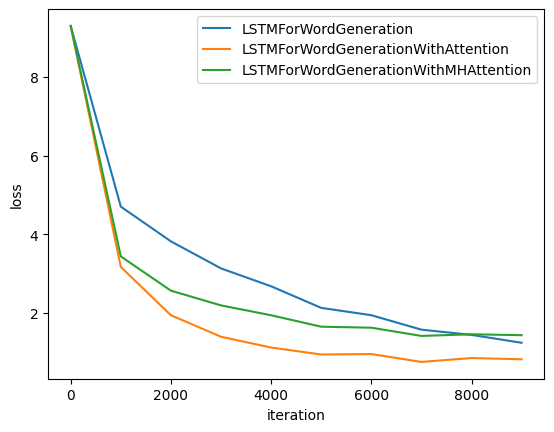

In [34]:
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
import pandas as pd

path = Path(TRAINED_MODELS_DIR+"_")    
models = list(path.iterdir())
for model_path in models:
    cd=pathlib.Path(model_path).joinpath("training_data.csv")
    td=pd.read_csv(cd)
    plt.plot(td.iteration, td.loss, label=model_path.name)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.legend()
plotpath=pathlib.Path("plots_and_outputs")
plotpath.mkdir(parents=True, exist_ok=True)
losspath=plotpath.joinpath("loss.png")
plt.savefig(losspath.resolve())

### Text generated by the model's write method

This part uses externally generated data in the "trained_models_" directory.

As the generated text data is saved with other data, generated text is extracted here.

 Text is generated after every 1000 training iterations (64 sequences of text per batch), first line of text is first generation and so on. I have put the generated texts in a single file per model.
 
 The text just contains 50 tokens, no beginning of sentence tokens, end of sentence tokens, unknown tokens. 'Ive' is a token for I've, just like 'were' is a token for we're, and more shortcuts.

 
 As the focus of this project is not to find the best tokenizer, but to find out whether I am able to adapt a model to generate more well formed texts, I don't want to find a better/other tokenizer.

In [35]:
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
import pandas as pd

path = Path(TRAINED_MODELS_DIR+"_")    
models = list(path.iterdir())
plotpath=pathlib.Path("plots_and_outputs")
plotpath.mkdir(parents=True, exist_ok=True)
for model_path in models:
    cd=pathlib.Path(model_path).joinpath("training_data.csv")
    td=pd.read_csv(cd)
    textpath=plotpath.joinpath(model_path.name+"/generated_text"+".txt")
    textpath.parent.mkdir(parents=True, exist_ok=True)
    print(str(textpath.resolve()))
    length=len(td["generated text"])
    with open(str(textpath.resolve()), "w") as f:
        for i,line in enumerate(td["generated text"]):
            if i<length-1:
                f.write(line + "\n")
            else:
                f.write(line)


C:\Users\wilfr\code-projects\lstms-for-generation\plots_and_outputs\LSTMForWordGeneration\generated_text.txt
C:\Users\wilfr\code-projects\lstms-for-generation\plots_and_outputs\LSTMForWordGenerationWithAttention\generated_text.txt
C:\Users\wilfr\code-projects\lstms-for-generation\plots_and_outputs\LSTMForWordGenerationWithMHAttention\generated_text.txt


Looking at the generated text results for the models I see good things and strange things. I have never written Harry Potter books, that is a somewhat unfortunate. I must say the pretrained models are fairly limited when considering embedded dimension and hidden lstm size. I also used limited training examples. 

In [36]:
%pip install torchview

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Create a visual overview of a model

As the models become complexer, it sometimes is a good idea to get an overview of a model. Especially when observing in- and output sizes of an module like lstm, attention, ....

The image generated by the code below is a complete overview, it would of course be possible to generate partial images by selecting specific pieces of the model and generate random data with correct dimensions for it. I am not going to focus on visualising parts of the model any further.
[Visual overview of the model with the multiheaded attention](trained_models\LSTMForWordGenerationWithMHAttention\visual_rep.gv.png)


In [37]:
from torchview import draw_graph
import gc
config=get_config_mh_attention()

dataset= get_databuildermemmap(config["max_len"], tokens, word2idx, idx2word, 'dat_mmap.dat')
input_texts, labels = dataset.grab_random_batch(batch_size=config["batch_size"])

model = LSTMForWordGenerationWithMHAttention(word2idx, idx2word, embedding_dim=config["embedding_dim"],
                                                 hidden_size=config["hidden_size"], n_layers=config["n_layers"],
                                                 bidirectional=config["bidirectional"], n_heads=config["n_heads"])

model_graph = draw_graph(model, input_texts, expand_nested=False, hide_inner_tensors=True,hide_module_functions=True, depth=1)
model_graph.visual_graph.save("trained_models/LSTMForWordGenerationWithMHAttention/visual_rep.gv")
md=model_graph.visual_graph
md.render(format="png").replace('\\', '/')



(process:20356): Pango-WARNING **: 03:45:37.450: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


'trained_models/LSTMForWordGenerationWithMHAttention/visual_rep.gv.png'

## Pytorch lightning

For future training and checkpointing scenarios, I have taken a look at Pytorch lightning. A library that provides all kinds of functionality when training, saving, logging training, validating. In the code snippets below I have mainly provided some code for checkpointing, logging; training and validation.

In [38]:
%pip install pytorch-lightning

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
import pytorch_lightning as PL
from torch.optim import AdamW
from torch.optim import lr_scheduler
import torch.nn.functional as F
import csv


### Callback to generate text

To generate text and write it to a file, every validation, I need a callback like below.

The code below generates text using the write and write_better methods.

In [40]:
class GenerateTextEveryNSteps(PL.Callback):
    def __init__(self, every_n_step):
        self.every_n_step = every_n_step
        self.file_columns_written = False
        self.file_columns_written_wb = False
    def on_validation_end(self, trainer, pl_module) -> None:
        if (trainer.global_step) % (self.every_n_step) == 0 and trainer.global_step != 0:
            trainer.model.eval()
            generated_text = pl_module.model.write(["Spells"], max_words=25)
            generated_texts, probs = pl_module.model.write_better(["Spells"], max_words=25, k=3)
            trainer.model.train()

            with open(pathlib.Path(pl_module.logger.log_dir).joinpath("generated_text.csv"), "a", newline='') as f:
                writer = csv.writer(f, delimiter='\t')
                if not self.file_columns_written:
                    writer.writerow(["epoch", "step", "generated_text"])
                    self.file_columns_written=True
                writer.writerow([str(trainer.current_epoch), str(trainer.global_step-1), generated_text])

            with open(pathlib.Path(pl_module.logger.log_dir).joinpath("generated_texts_write_better.csv"), "a", newline='') as f:
                writer = csv.writer(f, delimiter='\t')
                if not self.file_columns_written_wb:
                    writer.writerow(["epoch", "step", "prob", "generated_text"])
                    self.file_columns_written_wb = True
                for generated_text, prob in zip(generated_texts,probs):
                    writer.writerow([str(trainer.current_epoch), str(trainer.global_step-1), str(np.round(prob.numpy(),10)),generated_text])

### Subclassing LightningModule

To allow for training, validation, callbacks, checkpointing and loss recording, I need to subclass the Lightning module. 

#### Training step

The training step automatically performs the training steps (optimizer.zerograd(), loss.backward(), optimizer.step()), so I don't need to add those to the training step. Loss and number of training items are recorded.

#### Validation step

Furthermore validation loss is calculated every fourth training batch. Validation loss is recorded, just like the number of items used to validate. 

#### Configuring optimizers 

Optimizers are configured.


The multiheaded attention based model from above is used in this case.

In [41]:
class PLLSTMForWordGenerationWithMHAttention(PL.LightningModule):
    def __init__(self, word2idx, idx2word,config):
        super().__init__()
        self.model = LSTMForWordGenerationWithMHAttention(word2idx, idx2word, config["embedding_dim"], config["hidden_size"],config["bidirectional"],config["n_layers"],config["n_heads"])
        self.config = config
        self.model_name =   self.model.__class__.__name__
        self.file_columns_written=False

    def get_model_name(self):
        return self.model_name

    def training_step(self, batch, batch_idx):
        loss=None
        self.model.train()
        x, y = batch
        logits = self.model(x)
        logits = logits.transpose(1, 2)
        loss = F.cross_entropy(logits, y.long())
        self.log('train_loss', loss, on_step = True, prog_bar = True, logger = True)
        self.log('num_train_items', int(x.size(0)), on_step=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        logits = logits.transpose(1, 2)
        loss = F.cross_entropy(logits, y.long())
        self.log('val_loss', loss, on_step=False, prog_bar=True, logger=True)
        self.log('num_val_items', int(x.size(0)), on_step=False, prog_bar=True, logger=True)
        return {'val_loss': loss}
   
    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.config["lr"])
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",min_lr=0.001,patience=3,threshold=0.2, factor=0.98) 
        return {'optimizer': optimizer, 'lr_scheduler': dict(scheduler=scheduler, monitor="val_loss", interval="step", frequency=16)}


### From some datasource to Torch Dataset en DataLoader

As pytorch-lightning expects torch dataloaders, I have created a new datasource from the original data generator. I also needed a validation dataset.

In [42]:
from torch.utils.data import Dataset, DataLoader, random_split
class HarryPotterDataset(Dataset):
    def __init__(self, path_to_memmap, shape_of_memmap,seq_len):
        self.seq_len = seq_len
        self.number_of_tokens = shape_of_memmap[0]
        self.path_to_memmap = path_to_memmap
        self.shape_of_memmap = shape_of_memmap
        self.tokens = np.memmap(self.path_to_memmap, dtype=np.int32, mode='r', shape=self.shape_of_memmap)

    def __len__(self):
        return self.number_of_tokens-self.seq_len

    def __getitem__(self, index):
        end =   index+ self.seq_len
        text_slice = self.tokens[index:end].copy()

        input_text = torch.from_numpy(text_slice[:-1])
        label = torch.from_numpy(text_slice[1:])

        return input_text, label

### Create dataloaders

The dataloaders are created here.

In [43]:
def get_hp_dataloader(seq_len, tokens, word2idx, batch_size):
    path_to_memmap, shape_of_memmap = create_memmap(tokens, word2idx, "data_mem5.dat")
    dataset = HarryPotterDataset(path_to_memmap, shape_of_memmap, seq_len)
    train_size = int(0.97 * len(dataset))
    val_size = len(dataset) - train_size
    train_subset, val_subset = random_split(dataset, [train_size, val_size])
    train_dataloader = DataLoader(train_subset, shuffle=True, batch_size=batch_size)
    val_dataloader = DataLoader(val_subset, shuffle=False, batch_size=16)
    return train_dataloader, val_dataloader

In [44]:
text = get_hp_text()
tokens = get_tokens()
word2idx, idx2word = get_2_vocabs()
config = get_config_mh_attention()
model = PLLSTMForWordGenerationWithMHAttention(word2idx, idx2word, config)

In [45]:
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import Trainer
import gc

### Finally using Pytorch-Lightning

By seeding everything, experiments become repeatable. Furthermore, I will write validation and training loss to a csv file, also the best (with lowest validation loss) two checkpoints will be kept during training. 

Every 16 train_steps checkpoints will be updated, validation will be done and learning rate will be logged (to see if the lr scheduler really works). 

The last trained model will always be kept, checkpointed is a better word actually. 

The previously created custom callback is used to generate text for the trained model at every epoch.

The Trainer is created using the checkpoint callback, the csv-logger, val_callback and the learning rate monitor.

The max_epochs is set to 2, every epoch the models are trained for maximum eight batches of 4 items. The val_check_interval validates every 16 batches, using 1 batch of 64 items.

The values for the scheduler are intended to provoque a change in the lr. In reality, most values used here would be different, I just wanted to show I could get Lightning to work.

#### Directory

The data, checkpoints and logging is generated in the 'lightning' directory.

#### Sidenote

As the models aren't really trained, they see only 256 examples per epoch, the write_better text generation method gives very repetitive results, but I see that as good thing, it means the multiheaded attention is still quiet pristine, it is too large to get trained using this few examples.

In [46]:
from wakepy import keep
seed_everything(42)

csv_logger = CSVLogger("lightning/logs/"+model.get_model_name(), name="csv")

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    filename="{version}/chkp_{epoch}_{step}_{val_loss:.2f}_{num_train_items}",
    mode="min",
    save_top_k=2,
    dirpath="lightning/"+model.get_model_name()+"/checkpoints/",
    every_n_train_steps=16,
    save_last=True,
    save_weights_only=True
)

val_callback = GenerateTextEveryNSteps(64)

lr_monitor = LearningRateMonitor(logging_interval='step')

trainer = Trainer(
    logger=[csv_logger],
    callbacks=[checkpoint_callback, val_callback, lr_monitor],
    precision=32,
    log_every_n_steps=1,
    val_check_interval=0.25,
    fast_dev_run=False,
    max_epochs=2,
    deterministic=True,
    limit_val_batches=64,
    limit_train_batches=64,
)

hp_train_dl, hp_val_dl = get_hp_dataloader(20, tokens, word2idx, 4)

with keep.running():
    trainer.fit(model, hp_train_dl, val_dataloaders=hp_val_dl)


Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type                                 | Params | Mode  | FLOPs
-------------------------------------------------------------------------------
0 | model | LSTMForWordGenerationWithMHAttention | 19.5 M | train | 0    
-------------------------------------------------------------------------------
19.5 M    Trainable params
0         Non-trainable params
19.5 M    Total params
78.112    Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\wilfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\wilfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


## Final thoughts

In this notebook some models were presented. Some questions remain unanswered still. Some ideas still not executed.

### Question and answers based on intuition

Does the attention do what it should do? To test that I need to test it on some quasi/semi predictable mathematical function. I should have to set up and train some lstm based model -this while also applying attention-, that tries to predict a mathematical function based on some previously recorded values. 

The cross entropy loss function compares a distribution to a single value, I should delve into that some more. I have actually done nothing more than to take it over from the original training routine from the original idea. 

### Other thoughts and questions

#### Training takes too long

At this very moment my computer is trying to train a more advanced 4-headed attention model, the first lstml layer has 4 layers and is bidirectional, the second layer contains only one. The embedded dimension is 256 and the hidden size is 512. My simple computer needs several days to train it using only small batches and limited iterations. I am curious, but after half of the training it has minmized the original 10 loss to 8. These kind of traiining times make it very hard to do some experimentation. And eventually see how bad/well my models perform.

#### Random configurations

I haven't tested random configurations, even though it may be possible to use arbitrary values for embedded and hidden sizes, number of layers, attention dimensions, bidirectionality. I know when changing configuration things, I sometimes had to adapt code. To make it work. As most dimensions are interdependent.

#### Dimensions and intransparancy

It sometimes was quiet a hassle to adjust all the dimensions to get them to interact. 

Some other difficult thing is the write_better method , I think it does what it should do, but as long as I don't have a trained model I can't prove it or I can't adapt it to make it better. It already is quiet hard to tell what it does exactly from looking at the code.

#### Training adaptation

I have heard about not using the generated token from the previous time-step, but using the expected token in the forward loop, to speed up training. But at first thought, it seems difficult to implement considering my current forward loop. Allthough I haven't really investigated the idea thoroughly.